<a href="https://colab.research.google.com/github/panupong-kha/ML/blob/main/Logistic_Regression/stock_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial code (Starter kit) https://github.com/ekaratnida/Applied-machine-learning/blob/master/Week05-Logistic/Stock_forecast.ipynb

## แนะนำการวิเคราะห์หุ้นด้วย yahoo finance https://www.ultimatepython.co/post/python-yahoo-finance

## ทฤษฎีและตัวอย่าง https://blog.quantinsti.com/machine-learning-logistic-regression-python/

## Install Libraries

In [ ]:
!pip install requests
!pip install lxml
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib

## Import Libraries

## ติดตั้ง talib กรณีรันใน google colab

In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

In [577]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import talib as ta # Technical Indicators
# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

## วิธีแก้ไขกรณี ติดตั้ง Ta-lib ไม่ได้ ใน Jupyter notebook บน macbook and windows
- https://blog.quantinsti.com/install-ta-lib-python/#install-ta-lib-on-macos
- https://blog.quantinsti.com/install-ta-lib-python/

## Step 1: เลือกหุ้น ที่ต้องการ ดูข้อมูลย้อนหลัง วันที่ 1 Jan 2023 to 31 Dec 2023 time frame: 1 ชั่วโมง ดึงข้อมูลจาก Yahoo finance

In [578]:
stock = yf.Ticker('NVDA')
interval = '1h'

start = '2023-01-01'
end = '2023-12-31'

stock_price_df = stock.history(interval='1h',start=start,end=end)
stock_price_df.head()
df = stock_price_df.copy().iloc[:, :4]
df.head()

,Open,High,Low,Close
Datetime,,,,
2023-01-03 09:30:00-05:00,148.509995,149.960007,143.070007,143.520004
2023-01-03 10:30:00-05:00,143.529999,143.570007,141.030106,141.960007
2023-01-03 11:30:00-05:00,141.949997,142.610001,140.960007,141.830093
2023-01-03 12:30:00-05:00,141.850006,142.860001,141.570007,142.789993
2023-01-03 13:30:00-05:00,142.800095,142.863098,142.029999,142.271698


## Step 2: Define Predictor/Independent Variables
- เราจะใช้ค่าเฉลี่ยเคลื่อนที่ 10 ชั่วโมง ความสัมพันธ์ ดัชนีความแข็งแกร่งสัมพัทธ์ (RSI) ความแตกต่างระหว่างราคาเปิดของชั่วโมงก่อนและชั่วโมงปัจจุบัน ความแตกต่างระหว่างราคาปิดของชั่วโมงก่อนและราคาเปิดของชั่วโมงปัจจุบัน นอกจากนี้ ราคาเปิด สูง ต่ำ และราคาปิดจะถูกนำมาใช้เป็นตัวบ่งชี้ในการคาดการณ์

In [579]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['Open-Close'] = df['Open'] - df['Close'].shift(1)
df['Open-Open'] = df['Open'] - df['Open'].shift(1)
df = df.dropna()
X_df = df.iloc[:,:9]
X = X_df.copy()
X.head()

,Open,High,Low,Close,S_10,Corr,RSI,Open-Close,Open-Open
Datetime,,,,,,,,,
2023-01-05 13:30:00-05:00,144.149994,144.539993,143.190002,143.389893,144.993156,-0.616264,46.748415,0.000000,1.179993
2023-01-05 14:30:00-05:00,143.380005,144.479996,142.800003,142.860001,144.596997,-0.469055,44.516848,-0.009888,-0.769989
2023-01-05 15:30:00-05:00,142.880005,143.070007,142.399994,142.660004,144.139998,0.002840,43.643167,0.020004,-0.500000
2023-01-06 09:30:00-05:00,144.740005,144.889999,140.339996,142.539993,143.839998,0.290795,43.079462,2.080002,1.860001
2023-01-06 10:30:00-05:00,142.539993,146.179993,142.404999,145.949997,143.767998,0.041407,59.567244,0.000000,-2.200012


## Step 3: Define Target/Dependent Variable
- The dependent variable is the same as discussed in the above example. If tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).

In [580]:
y = np.where(df['Close'].shift(-1) > df['Close'],1,-1) #ปิดชั่วโมงถัดไป มากกว่า ปิดชั่วโมงนี้
y

array([-1, -1, -1, ..., -1, -1, -1])

## Step 4: Split The Dataset
- We will split the dataset into a training dataset and test dataset. We will use 70% of our data to train and the rest 30% to test. To do this, we will create a split variable which will divide the data frame in a 70-30 ratio. ‘Xtrain’ and ‘Ytrain’ are train dataset. ‘Xtest’ and ‘Ytest’ are the test dataset.

In [581]:
split = int(0.7*len(df))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

## Step 5: Instantiate The Logistic Regression in Python
- We will instantiate the logistic regression in Python using ‘LogisticRegression’ function and fit the model on the training dataset using ‘fit’ function.

In [582]:
model = LogisticRegression(max_iter=1000)
model = model.fit (X_train,y_train)

## Step 6: Examine The Coefficients

In [583]:
pd.DataFrame(zip(X_df.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.05298236352506645]
1,High,[0.03964496662330582]
2,Low,[0.024764484584944065]
3,Close,[-0.02936185720356232]
4,S_10,[0.01748193678928583]
5,Corr,[-0.012345432700796962]
6,RSI,[0.004863282358084959]
7,Open-Close,[0.0029761989010938738]
8,Open-Open,[0.026768104572008854]


## Step 7: Calculate Class Probabilities
- We will calculate the probabilities of the class for the test dataset using ‘predict_proba’ function.

In [584]:
# Specify the date for prediction
prediction_date = '2024-03-31'
probability = model.predict_proba(X_test)
probability

array([[0.48964439, 0.51035561],
       [0.49167799, 0.50832201],
       [0.46287346, 0.53712654],
       ...,
       [0.42588935, 0.57411065],
       [0.45636622, 0.54363378],
       [0.50244071, 0.49755929]])

## Step 8: Predict Class Labels
- Next, we will predict the class labels using predict function for the test dataset.
- In the output above, the signal shows 1, which is a buy signal
- -1 is a sell signal

In [585]:
predicted = model.predict(X_test)
predicted

array([ 1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
       -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,
        1,  1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1,  1,  1,
        1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
       -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
        1, -1,  1,  1,  1

## Step 9: Evaluate The Model
## 9.1 Confusion Matrix
- The Confusion matrix is used to describe the performance of the classification model on a set of test dataset for which the true values are known. We will calculate the confusion matrix using ‘confusion_matrix’ function.

In [586]:
print(metrics.confusion_matrix(y_test, predicted))

[[ 55 194]
 [ 39 230]]


## 9.2 Classification Report
- This is another method to examine the performance of the classification model.

In [587]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

          -1       0.59      0.22      0.32       249
           1       0.54      0.86      0.66       269

    accuracy                           0.55       518
   macro avg       0.56      0.54      0.49       518
weighted avg       0.56      0.55      0.50       518



- The f1-score tells you the accuracy of the classifier in classifying the data points in that particular class compared to all other class. It is calculated by taking the harmonic mean of precision and recall. The support is the number of samples of the true response that lies in that class.
- The accuracy of the model is at 0.52 or 52%.

## 9.3 Model Accuracy

- We will calculate the model accuracy on the test dataset using ‘score’ function.

In [588]:
print(model.score(X_test,y_test))

0.5501930501930502


## 9.4 Cross-Validation

- We will cross-check the accuracy of the model using 10-fold cross-validation. For this, we will use ‘crossvalscore’ function which we have imported from ‘sklearn.cross_validation’ library.

In [589]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.53179191 0.52601156 0.52601156 0.50867052 0.51744186 0.53488372
 0.44186047 0.58139535 0.54069767 0.51744186]
0.5226206479365505


- The accuracy is still 52.64% which means the model is working fine.

## Step 10: Create Trading Strategy Using The Model

- We will predict the signal to buy (1) or sell (-1) and calculate the cumulative Berkshire_Hathaway returns for the test dataset. Next, we will calculate the cumulative strategy return based on the signal predicted by the model in the test dataset. We will also plot the cumulative returns.

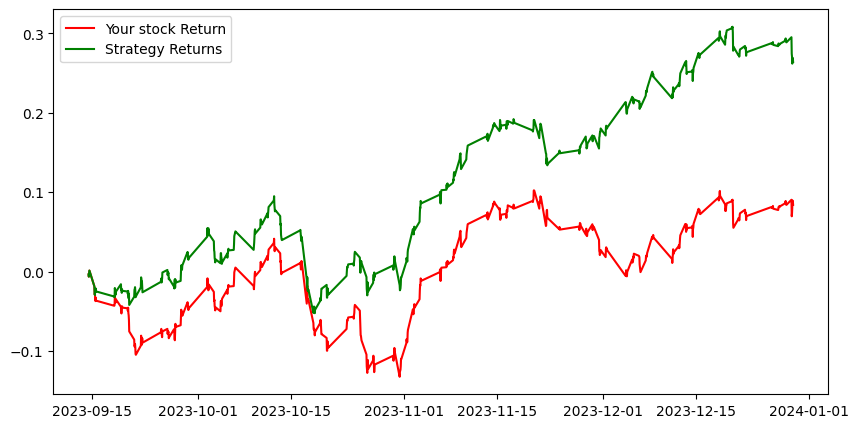

In [590]:
df['Predicted_Signal'] = model.predict(X)
df['Nvidia_returns'] = np.log(df['Close']/df['Close'].shift(1))
Cumulative_Nvidia_returns = np.cumsum(df[split:]['Nvidia_returns'])

df['Startegy_returns'] = df['Nvidia_returns']* df['Predicted_Signal'].shift(1)
Cumulative_Strategy_returns = np.cumsum(df[split:]['Startegy_returns'])

plt.figure(figsize=(10,5))
plt.plot(Cumulative_Nvidia_returns, color='r',label = 'Your stock Return')
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

## เพิ่ม column Open กับ close

## Step 1: Import Data

In [591]:
stock_2 = yf.Ticker('AMD')

interval = '1h'

start = '2023-01-01'
end = '2023-12-31'

stock_2_price_df = stock_2.history(interval='1h',start=start,end=end)
stock_2_price_df['y'] = np.where(stock_2_price_df['Close'].shift(-1) > stock_2_price_df['Close'],1,-1)
df2 = stock_2_price_df[["Close","y"]]
df2 = pd.DataFrame(df2)
df2.head()

,Close,y
Datetime,,
2023-01-03 09:30:00-05:00,64.455002,-1
2023-01-03 10:30:00-05:00,64.208000,-1
2023-01-03 11:30:00-05:00,64.095001,1
2023-01-03 12:30:00-05:00,64.135002,-1
2023-01-03 13:30:00-05:00,63.869999,1


## Step 2:  Define Predictor/Independent Variables
- เอา df2 ที่เป็นตัวแปรราคาปิดและราคาเปิดของหุ้น AMD ไป merge กับ df1 ที่เป็นข้อมูลหุ้นของ NVDA โดยยึด row index "Datetime"

In [592]:
merged_df = pd.merge(df.iloc[:,:9], df2,on='Datetime', how='inner')
merged_df.head()

,Open,High,Low,Close_x,S_10,Corr,RSI,Open-Close,Open-Open,Close_y,y
Datetime,,,,,,,,,,,
2023-01-05 13:30:00-05:00,144.149994,144.539993,143.190002,143.389893,144.993156,-0.616264,46.748415,0.000000,1.179993,63.125000,-1
2023-01-05 14:30:00-05:00,143.380005,144.479996,142.800003,142.860001,144.596997,-0.469055,44.516848,-0.009888,-0.769989,62.512001,-1
2023-01-05 15:30:00-05:00,142.880005,143.070007,142.399994,142.660004,144.139998,0.002840,43.643167,0.020004,-0.500000,62.340000,-1
2023-01-06 09:30:00-05:00,144.740005,144.889999,140.339996,142.539993,143.839998,0.290795,43.079462,2.080002,1.860001,60.964500,1
2023-01-06 10:30:00-05:00,142.539993,146.179993,142.404999,145.949997,143.767998,0.041407,59.567244,0.000000,-2.200012,61.623100,1


In [593]:
merged_df.rename(columns={'Close_x': 'Close_stock'}, inplace=True)
merged_df.rename(columns={'Close_y': 'Close_stock_2'}, inplace=True)
merged_df.rename(columns={'y': 'y_amd'}, inplace=True)

Xb_df = merged_df.iloc[:,:11]

Xb = Xb_df.copy()

Xb.head()

,Open,High,Low,Close_stock,S_10,Corr,RSI,Open-Close,Open-Open,Close_stock_2,y_amd
Datetime,,,,,,,,,,,
2023-01-05 13:30:00-05:00,144.149994,144.539993,143.190002,143.389893,144.993156,-0.616264,46.748415,0.000000,1.179993,63.125000,-1
2023-01-05 14:30:00-05:00,143.380005,144.479996,142.800003,142.860001,144.596997,-0.469055,44.516848,-0.009888,-0.769989,62.512001,-1
2023-01-05 15:30:00-05:00,142.880005,143.070007,142.399994,142.660004,144.139998,0.002840,43.643167,0.020004,-0.500000,62.340000,-1
2023-01-06 09:30:00-05:00,144.740005,144.889999,140.339996,142.539993,143.839998,0.290795,43.079462,2.080002,1.860001,60.964500,1
2023-01-06 10:30:00-05:00,142.539993,146.179993,142.404999,145.949997,143.767998,0.041407,59.567244,0.000000,-2.200012,61.623100,1


##Step 3: Define Target/Dependent Variable
- The dependent variable is the same as discussed in the above example. If tomorrow’s closing price is higher than today’s closing price, then we will buy the stock (1), else we will sell it (-1).

In [594]:
yb = np.where(merged_df['Close_stock'].shift(-1) > merged_df['Close_stock'],1,-1)
yb

array([-1, -1, -1, ..., -1, -1, -1])

## Step 4: Split The Dataset
- แบ่งข้อมูลสำหรับ Train 70% และ test  30%

In [595]:
splitb = int(0.7*len(merged_df))
Xb_train, Xb_test, yb_train, yb_test = Xb[:splitb], Xb[splitb:], yb[:splitb], yb[splitb:]

## Step 5: Logistic Regression

In [596]:
modelb = LogisticRegression(max_iter=1000)
modelb = modelb.fit(Xb_train,yb_train)

## Step 6: Examine The Coefficients

In [597]:
pd.DataFrame(zip(Xb_df.columns, np.transpose(modelb.coef_)))

,0,1
0,Open,[-0.011723627912464634]
1,High,[0.013784658573916858]
2,Low,[-0.02160416941445661]
3,Close_stock,[0.004831409034138213]
4,S_10,[0.013818127978577295]
5,Corr,[0.13888733752826957]
6,RSI,[0.00228790229611041]
7,Open-Close,[-0.02485285597683228]
8,Open-Open,[0.033172002784565495]
9,Close_stock_2,[0.0020268096544928814]


## Step 7: Calculate Class Probabilities
- We will calculate the probabilities of the class for the test dataset using ‘predict_proba’ function.

In [598]:
# Specify the date for prediction
predictionb_date = '2024-03-31'
probabilityb = modelb.predict_proba(Xb_test)
probabilityb

array([[0.78367983, 0.21632017],
       [0.27668731, 0.72331269],
       [0.76909664, 0.23090336],
       ...,
       [0.70659766, 0.29340234],
       [0.73037716, 0.26962284],
       [0.75489852, 0.24510148]])

## Step 8: Predict Class Labels
- Next, we will predict the class labels using predict function for the test dataset.
- In the output above, the signal shows 1, which is a buy signal
- -1 is a sell signal

In [599]:
predictedb = modelb.predict(Xb_test)
predictedb

array([-1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,
       -1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1, -1, -1, -1, -1, -1,  1,
        1, -1, -1,  1,  1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1,
        1, -1, -1,  1, -1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,  1,  1,
        1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1,
        1,  1, -1, -1,  1, -1, -1, -1,  1,  1,  1,  1, -1,  1,  1, -1, -1,
       -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1, -1, -1, -1,  1,  1,
        1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
        1,  1, -1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,  1, -1, -1,
       -1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,
        1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1, -1,  1,
        1, -1, -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1,  1, -1, -1, -1, -1,  1,  1, -1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1,  1,  1,  1,  1

## Step 9: Evaluate The Model

## 9.1 Confusion Matrix

In [600]:
print(metrics.confusion_matrix(yb_test, predictedb))

[[187  62]
 [ 61 208]]


## 9.2 Classification Report

In [601]:
print(metrics.classification_report(yb_test, predictedb))

              precision    recall  f1-score   support

          -1       0.75      0.75      0.75       249
           1       0.77      0.77      0.77       269

    accuracy                           0.76       518
   macro avg       0.76      0.76      0.76       518
weighted avg       0.76      0.76      0.76       518



## 9.3 Model Accuracy

In [602]:
print(modelb.score(Xb_test,yb_test))

0.7625482625482626


## 9.4 Cross-Validation

In [603]:
cross_val = cross_val_score(LogisticRegression(), Xb, yb, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

[0.8150289  0.77456647 0.77456647 0.68786127 0.68604651 0.80232558
 0.72093023 0.86627907 0.71511628 0.69767442]
0.7540395214410539


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Step 8: Create Trading Strategy Using The Model

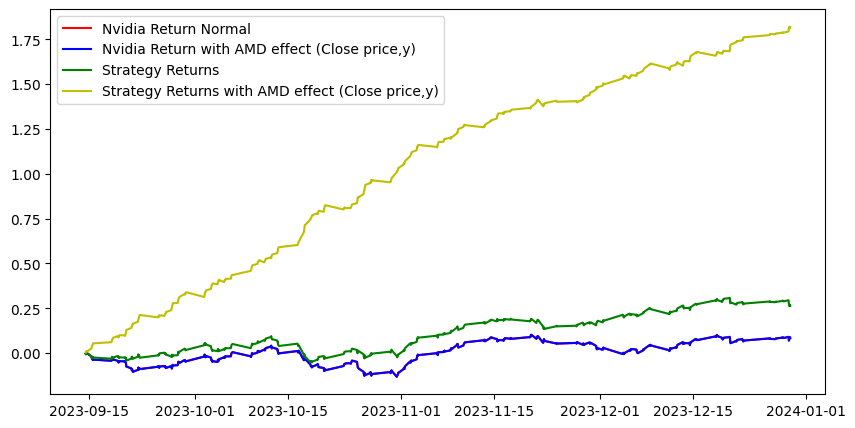

In [604]:
plt.figure(figsize=(10,5))

##เส้นที่ 1 ผลตอบแทนจริงของ Nvidia กรณีปกติ
plt.plot(Cumulative_Nvidia_returns, color='r',label = 'Nvidia Return Normal')


##เส้นที่ 2 ผลตอบแทนจริงของ Nvidia กรณีที่เอาราคาปิดและ y ของ AMD มาวิเคราะห์ร่วม/
merged_df['Predicted_Signalb'] = modelb.predict(Xb)
merged_df['nvda_amd'] = np.log(merged_df['Close_stock']/merged_df['Close_stock'].shift(1))
Cumulative_nvda_amd_returns = np.cumsum(merged_df[splitb:]['nvda_amd'])
plt.plot(Cumulative_nvda_amd_returns, color='b',label = 'Nvidia Return with AMD effect (Close price,y)')

##เส้นที่ 3 ผลตอบแทนของตาม model กรณีปกติ
plt.plot(Cumulative_Strategy_returns, color='g', label = 'Strategy Returns')


##เส้นที่ 4 ผลตอบแทนของตาม model กรณีที่เอาราคาปิดและ y ของ AMD มาวิเคราะห์ร่วม
merged_df['Strategy_returnsb'] = merged_df['nvda_amd']* merged_df['Predicted_Signalb'].shift(1)
Cumulative_Strategy_returnsb = np.cumsum(merged_df[splitb:]['Strategy_returnsb'])
plt.plot(Cumulative_Strategy_returnsb, color='y', label = 'Strategy Returns with AMD effect (Close price,y)')


plt.legend()
plt.show()